Today we continue the [saga on gradient boosting](/gradient-boosting-series/)
 with a down-to-Earth tutorial on the essentials of solving classification problems with XGBoost.
We'll run through two examples: one for binary classification and another for multi-class classification.
In both cases I'll show you how to train XGBoost models using either the scikit-learn interface or the native xgboost library interface.
We'll have a look at some basic model evaluation metrics for classifiers and then wrap it up with a (mostly) rant-free demo on getting non-useless feature importance for these XGBoost models.

![A blistering afternoon in the Masai Mara](xgboost-classification-main.jpg "")

## Preparing Data for XGBoost Classifier

Our dataset must satisfy two requirements to be used in an XGBoost classifier.
First all feature data must be numeric&mdash;no strings and no datetimes;
if you have non-numeric features, you need to [transform your feature data](/posts/xgboost-for-regression-in-python/#prepare-raw-data-for-xgboost).
Second, the target must be integer encoded using $\{0,1\}$ for binary targets and $\{0,1,\dots,K\}$ for multiclass targets.
Note that if your data is encoded to positive integers (no 0 class) XGBoost will throw potentially cryptic errors.
You can use the scikit-learn 
[`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
(which we'll do below) to generate a valid target encoding.

### XGBoost Training APIs: `train` function and `XGBClassifier` wrapper

The `xgboost` python library offers two API's for training classification models:  the native 
[`train`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
function and a wrapper class called 
[`XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn),
which offers an API consistent with the scikit-learn universe.
I'll show you how to use both approaches in the examples below, but if you're planning to use other utilities from scikit-learn, you might find the `XGBClassifier` approach to be more convenient, since the trained model object will generally play nice with sklearn functionality.

## Binary Classification Example

### Breast Cancer Wisconsin Dataset
We'll demonstrate binary classification in XGBoost using the
[breast cancer wisconsin data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer),
one of scikit-learn's built-in toy datasets.
This is a tiny dataset with 569 observations of 30 features and a binary target representing whether samples are malignant or benign..

In [210]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets

dbunch = datasets.load_breast_cancer(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
target_names = dbunch.target_names 
target = 'target' 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In this dataset, the features are all numeric, so no need to do preprocessing before passing to XGBoost.
Below we'll have a look at the target to ensure it's encoded in $\{0,1\}$ and to check the class balance.

In [211]:
df[target].unique(), target_names

(array([0, 1]), array(['malignant', 'benign'], dtype='<U9'))

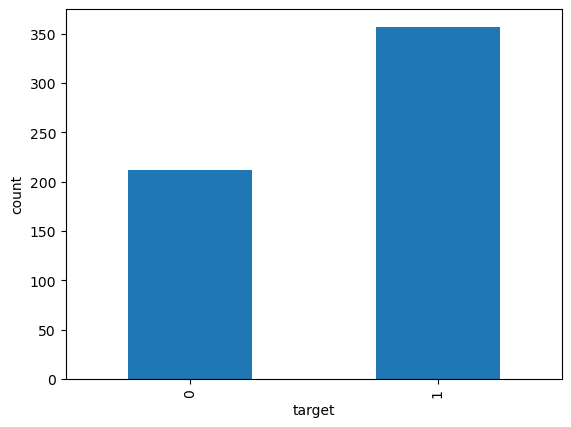

In [212]:
#| fig-alt: bar plot showing the count of observations in each class
#| fig-cap: class counts for the breast cancer dataset

df.target.value_counts().sort_index().plot.bar()
plt.xlabel('target') 
plt.ylabel('count');

Next We randomly split data into train and validation sets.

In [216]:
from sklearn.model_selection import train_test_split

n_valid = 50 

train_df, valid_df = train_test_split(df, test_size=n_valid, random_state=42)
train_df.shape, valid_df.shape

((519, 31), (50, 31))

### Training with the  `train` function

We need to set a couple of
[model parameters](https://xgboost.readthedocs.io/en/stable/parameter.html),
most notably `objective`, which should be set to `binary:logistic` for binary classification.
I also prefer to explicitly set `tree_method` to something other than its default of `auto`;
usually I'll start with `exact` on small datasets or `approx` on larger ones.
Note also that The `train` function expects to receive data as `DMatrix` objects, not pandas dataframes, so we need to create dense matrix objects as well.

In [224]:
params = {
    'tree_method': 'exact',
    'objective': 'binary:logistic',
}
num_boost_round = 50

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10)

[0]	train-logloss:0.46232	valid-logloss:0.49033
[10]	train-logloss:0.04394	valid-logloss:0.13434


[20]	train-logloss:0.01515	valid-logloss:0.12193
[30]	train-logloss:0.00995	valid-logloss:0.11988
[40]	train-logloss:0.00766	valid-logloss:0.12416
[49]	train-logloss:0.00657	valid-logloss:0.12799


### Training with `XGBClassifier`

The `XGBClassifier` takes dataframes or numpy arrays as input, so this time we don't need to create those dense matrix objects.

In [225]:
params = {
    'tree_method': 'exact',
    'objective': 'binary:logistic',
}
num_boost_round = 50

clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-logloss:0.46232	validation_1-logloss:0.49033
[10]	validation_0-logloss:0.04394	validation_1-logloss:0.13434


[20]	validation_0-logloss:0.01515	validation_1-logloss:0.12193
[30]	validation_0-logloss:0.00995	validation_1-logloss:0.11988
[40]	validation_0-logloss:0.00766	validation_1-logloss:0.12416
[49]	validation_0-logloss:0.00657	validation_1-logloss:0.12799


### Evaluating the Model

We'll use the `sklearn.metrics` module
to evaluate model performance on the held-out validation set.
Have a look at the 
[scikit-learn metrics for classification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
for examples of other metrics to use.

One thing to watch out for when computing metrics is the difference between the actual labels (usually called `y_true`), the model's predicted labels (usually called `y_pred`), and the models predicted probabilities (usually called `y_score`).
If you're using the `XGBClassifier` wrapper, you can get predicted labels with the `predict` method and predicted probabilities with the `predict_proba` method.
Also note that whereas `predict` returns a vector of size (num data), `predict_proba` returns a vector of size (num data, num classes); thus for binary classification, we'll take just the second column of the array which gives the probability of class 1.

In [220]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])[:,1]

Probably the simplest classification metric is accuracy, the proportion of labels we predicted correctly.

In [226]:
from sklearn import metrics 

metrics.accuracy_score(y_true, y_pred)

0.96

We can generate a classification report with several different metrics at once.

In [227]:
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        15
      benign       0.97      0.97      0.97        35

    accuracy                           0.96        50
   macro avg       0.95      0.95      0.95        50
weighted avg       0.96      0.96      0.96        50



And we can compute the AUC, a popular classification metric based on the ROC curve, which depends on the predicted probability rather than the predicted labels.

In [228]:
metrics.roc_auc_score(y_true, y_score)

0.9885714285714287

### Feature Importance

Because of the 
[limitations of the built-in XGBoost feature importance metrics](/posts/xgboost-for-regression-in-python/#feature-importance-for-xgboost)
I recommend that you use either [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
or perhaps [SHAP feature importance](https://shap.readthedocs.io/en/latest/index.html).

Here we'll compute the permutation feature importance, which tells us by how much the model's performance changes when we scramble a particular feature's values at prediction time.
This reflects how much the model relies on each feature when making predictions.

In [229]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

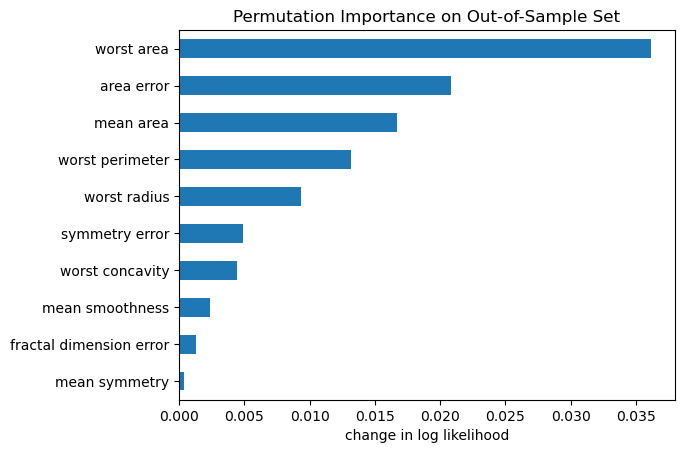

In [230]:
#| fig-alt: horizontal bar plot showing permutation feature importance
#| fig-cap: top 10 features by permutation importance on validation set

importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in log likelihood');


## Multi-Class Classification Example

### Forest Cover Dataset
We'll illustrate multi-class classification using the 
[scikit-learn forest cover type dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype),
which has around 580k observations of 54 features and a target with 7 classes.

In [231]:
dbunch = datasets.fetch_covtype(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

Here again the features are all numeric, so we don't need to further preprocess them.
Let's have a look at the target.

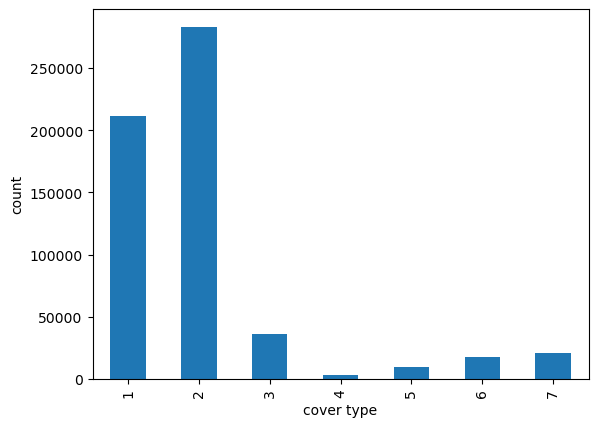

In [232]:
#| fig-alt: bar plot showing the count of observations in each class
#| fig-cap: class counts for the forest cover type dataset

df['Cover_Type'].value_counts().sort_index().plot.bar()
plt.xlabel('cover type') 
plt.ylabel('count');

For multi-class classification, our target variable must take values in $\{0,1,\dots,K\}$.
However, from the histogram of the cover type above, we see that it takes values in $\{1,2,\dots,7\}$.
To fix this we can use the [scikit-learn label encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) 
to create a valid target column.

In [240]:
from sklearn.preprocessing import LabelEncoder 

target = 'encoded'
enc = LabelEncoder()
df[target] = enc.fit_transform(df['Cover_Type'])
print(np.sort(df[target].unique()))

[0 1 2 3 4 5 6]


Then we can create training and validation sets.

In [241]:
n_valid = 20000

train_df, valid_df = train_test_split(df, test_size=n_valid, random_state=42)
train_df.shape, valid_df.shape

((561012, 56), (20000, 56))

### Training with the `train` function

If you're training with the `train` function, multi-class classification can be done with two objectives: `multi:softmax` and `multi:softprob`. 
Both use the same loss function, negative multinomial log likelihood, but the softmax option produces a trained `Booster` object whose predict method returns a 1d array of predicted labels, whereas the softprob option produces a trained `Booster` object whose predict method returns a 2d array of predicted probabilities.
In either case, you also need to explicitly tell XGBoost how many classes the target has with the `num_class` parameter.

In [242]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
    'num_class': df[target].nunique()
}
num_boost_round = 10

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=2)

[0]	train-mlogloss:1.42032	valid-mlogloss:1.42366
[2]	train-mlogloss:1.00541	valid-mlogloss:1.00963
[4]	train-mlogloss:0.80557	valid-mlogloss:0.81109
[6]	train-mlogloss:0.69432	valid-mlogloss:0.70085
[8]	train-mlogloss:0.62653	valid-mlogloss:0.63350
[9]	train-mlogloss:0.60111	valid-mlogloss:0.60794


### Training with `XGBClassifier`

In multi-class classification, I think  the scikit-learn `XGBClassifier` wrapper is quite a bit more convenient than the native `train` function.
You can set the `objective` parameter to `multi:softprob`, and `XGBClassifier.fit` will produce a model having both `predict` and `predict_proba` methods.
Also there is no need to explicitly set the number of classes in the target and no need to create the `DMatrix` objects.

In [243]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
}
num_boost_round = 10

clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=2);

[0]	validation_0-mlogloss:1.42032	validation_1-mlogloss:1.42366
[2]	validation_0-mlogloss:1.00541	validation_1-mlogloss:1.00963
[4]	validation_0-mlogloss:0.80557	validation_1-mlogloss:0.81109
[6]	validation_0-mlogloss:0.69432	validation_1-mlogloss:0.70085
[8]	validation_0-mlogloss:0.62653	validation_1-mlogloss:0.63350
[9]	validation_0-mlogloss:0.60111	validation_1-mlogloss:0.60794


### Evaluating the Model

This time, we'll kee; the entire 2d array of predicted probabilities in `y_score`.

In [245]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])
y_true.shape, y_pred.shape, y_score.shape

((20000,), (20000,), (20000, 7))

In [246]:
metrics.accuracy_score(y_true, y_pred)

0.77425

In [247]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      7365
           1       0.78      0.84      0.81      9725
           2       0.75      0.85      0.80      1207
           3       0.82      0.78      0.80        85
           4       0.93      0.26      0.40       317
           5       0.76      0.31      0.44       627
           6       0.88      0.68      0.77       674

    accuracy                           0.77     20000
   macro avg       0.81      0.64      0.68     20000
weighted avg       0.78      0.77      0.77     20000



Some binary classification metrics, like AUC, can be extended to the multi-class setting
by computing the metric for each class, then averaging in some way to get an overall score. 
The details are controlled by the `average` and `multi_class` parameters, which are described in the
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [248]:
metrics.roc_auc_score(y_true, y_score, average='weighted', multi_class='ovr')

0.9129422094408693

### Feature Importance

We can compute permutation feature importance with exactly the same code that we used for the binary classifier.

In [249]:
scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

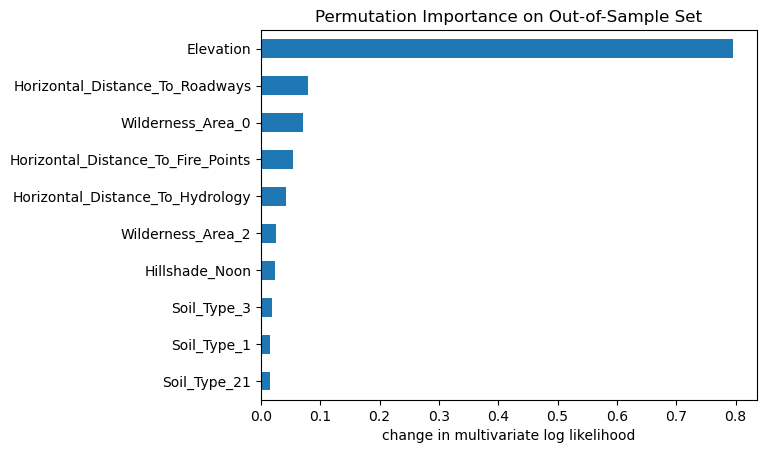

In [250]:
#| fig-alt: horizontal bar plot showing permutation feature importance
#| fig-cap: top 10 features by permutation importance on validation set

importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in multivariate log likelihood');


## Wrapping Up

Well, for me, those are really the minimal nuts and bolts one needs to get XGBoost models working on classification problems.
If you dig this tutorial, or if you have additional insights into using XGBoost to solve classification problems, let me know about it down in the comments!

## Go Deeper

If you're feeling like Alice, and you want to go tumbling down the rabbit hole, might I recommend checking out some of the following:

* [XGBoost Explained](/posts/xgboost-explained/) - for a deep dive into the math 
* [XGBoost from Scratch](/posts/xgboost-from-scratch/) - to really understand how XGBoost works
* [Multi-Class Gradient Boosting from Scratch](/posts/gradient-boosting-multi-class-classification-from-scratch/) - to fully grok the multi-class gradient boosting algorithm